In [43]:
def get_today_date():
    from datetime import datetime
    date_str = str(datetime.now())
    today=datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S.%f')
    return today.strftime('%d-%b-%Y')

symbol ='BANKNIFTY'
lot = 25
# today = get_today_date()
# today = '06-Oct-2022'
# today_ex=get_today_date_nsepy()

# today_ex = '2022-Oct-06'
# expiry='2022-Oct-27'

expiry_group = '27-Oct-2022'

day = 6
month ='Oct'
year = '2022'

In [44]:
if day < 10 :
    val ='0'+str(day)
    today = val+"-"+month+"-"+year
else:
    today = str(day)+"-"+month+"-"+year
# today

In [45]:
from datetime import datetime,timedelta
s=datetime.strptime(today,'%d-%b-%Y')
e =datetime.strptime(expiry_group,'%d-%b-%Y')

today_ex = s.strftime('%Y-%b-%d')
expiry = e.strftime('%Y-%b-%d')

In [46]:
def get_today_date():
    from datetime import datetime
    date_str = str(datetime.now())
    today=datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S.%f')
    return today.strftime('%d-%b-%Y')

def get_hh_mm_time(data_df):
    data_df["timestamp"] = pd.to_datetime(data_df["timestamp"])
    data_df["timestamp"] = data_df["timestamp"].dt.strftime('%H:%M')
    return data_df

def get_path_filename(filename):
    path='D:\Jupyter Python\Stocks-office\json-csv\\'
    newFilename=path+filename
    return newFilename

def get_options_ohlc_csv(symbol):
        # today = get_today_date()
        # today = '13-Sep-2022'
        filename = symbol + '-FULL-OPTIONS-OHLC-' + today + ".csv"
        filename=get_path_filename(filename)
        df=pd.read_csv(filename,index_col=False)#<<<<<<<<<<<<<<<<<<<<<<<<<<index column is False
        return df
    
def f(df):
    if df["pchangeinOpenInterest"]>0 and df["change"]>0:
        val= "LB"
    elif df["pchangeinOpenInterest"]<0 and df["change"]<0:
        val="LW"
    elif df["pchangeinOpenInterest"]<0 and df["change"]>0:
        val="SC"
    elif df["pchangeinOpenInterest"]>0 and df["change"]<0:
        val="SB"
    else:
        val=np.nan
    return val

def colour_numbers(series):
        red    = 'background-color: orangered;'
        orange = 'background-color: olive;' 
        blue = 'background-color: royalblue;' 
        green = 'background-color: seagreen;' 

        default = ''

        # note multiple else ..if conditions
        return [red if e == 'SB' else green if e == 'LB' else orange if e == 'LW' else blue if e == 'SC' else default for e in series] 
   

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings("ignore")

# symbol ='BANKNIFTY'
# lot = 25
# today = get_today_date()

df_f = get_options_ohlc_csv(symbol) # read csv file by option type
df_f=get_hh_mm_time(df_f)

g1_fut=df_f.groupby('instrumentType')
df_fut = g1_fut.get_group('Index Futures')
g2_fut= df_fut.groupby('expiryDate')
df_fut_current = g2_fut.get_group(expiry_group)

df_fut_current_reorder=df_fut_current[[
    'timestamp','openInterest','changeinOpenInterest','highPrice', 'lowPrice', 'tradedVolume','lastPrice', 'change','vmap','pchangeinOpenInterest','prevClose'
]]

# df_fut_current_reorder=df_fut_current_reorder[df_fut_current_reorder["timestamp"]!='15:30'] # for droping yesterday data in today csv
df_fut_current_reorder=df_fut_current_reorder[df_fut_current_reorder["openInterest"]!=0] # for droping yesterday data in today csv




df_fut_current_reorder[["openInterest",'changeinOpenInterest']]=df_fut_current_reorder[["openInterest","changeinOpenInterest"]]*lot
df_fut_current_reorder["changeLastprice"]=df_fut_current_reorder["lastPrice"]-df_fut_current_reorder["lastPrice"].shift(1)
df_fut_current_reorder['buildup'] = df_fut_current_reorder.apply(f, axis=1)
df_fut_current_reorder=df_fut_current_reorder.reset_index()
df_fut_current_reorder.drop("index",axis=1,inplace=True)



## Futures charts vwap and open interest

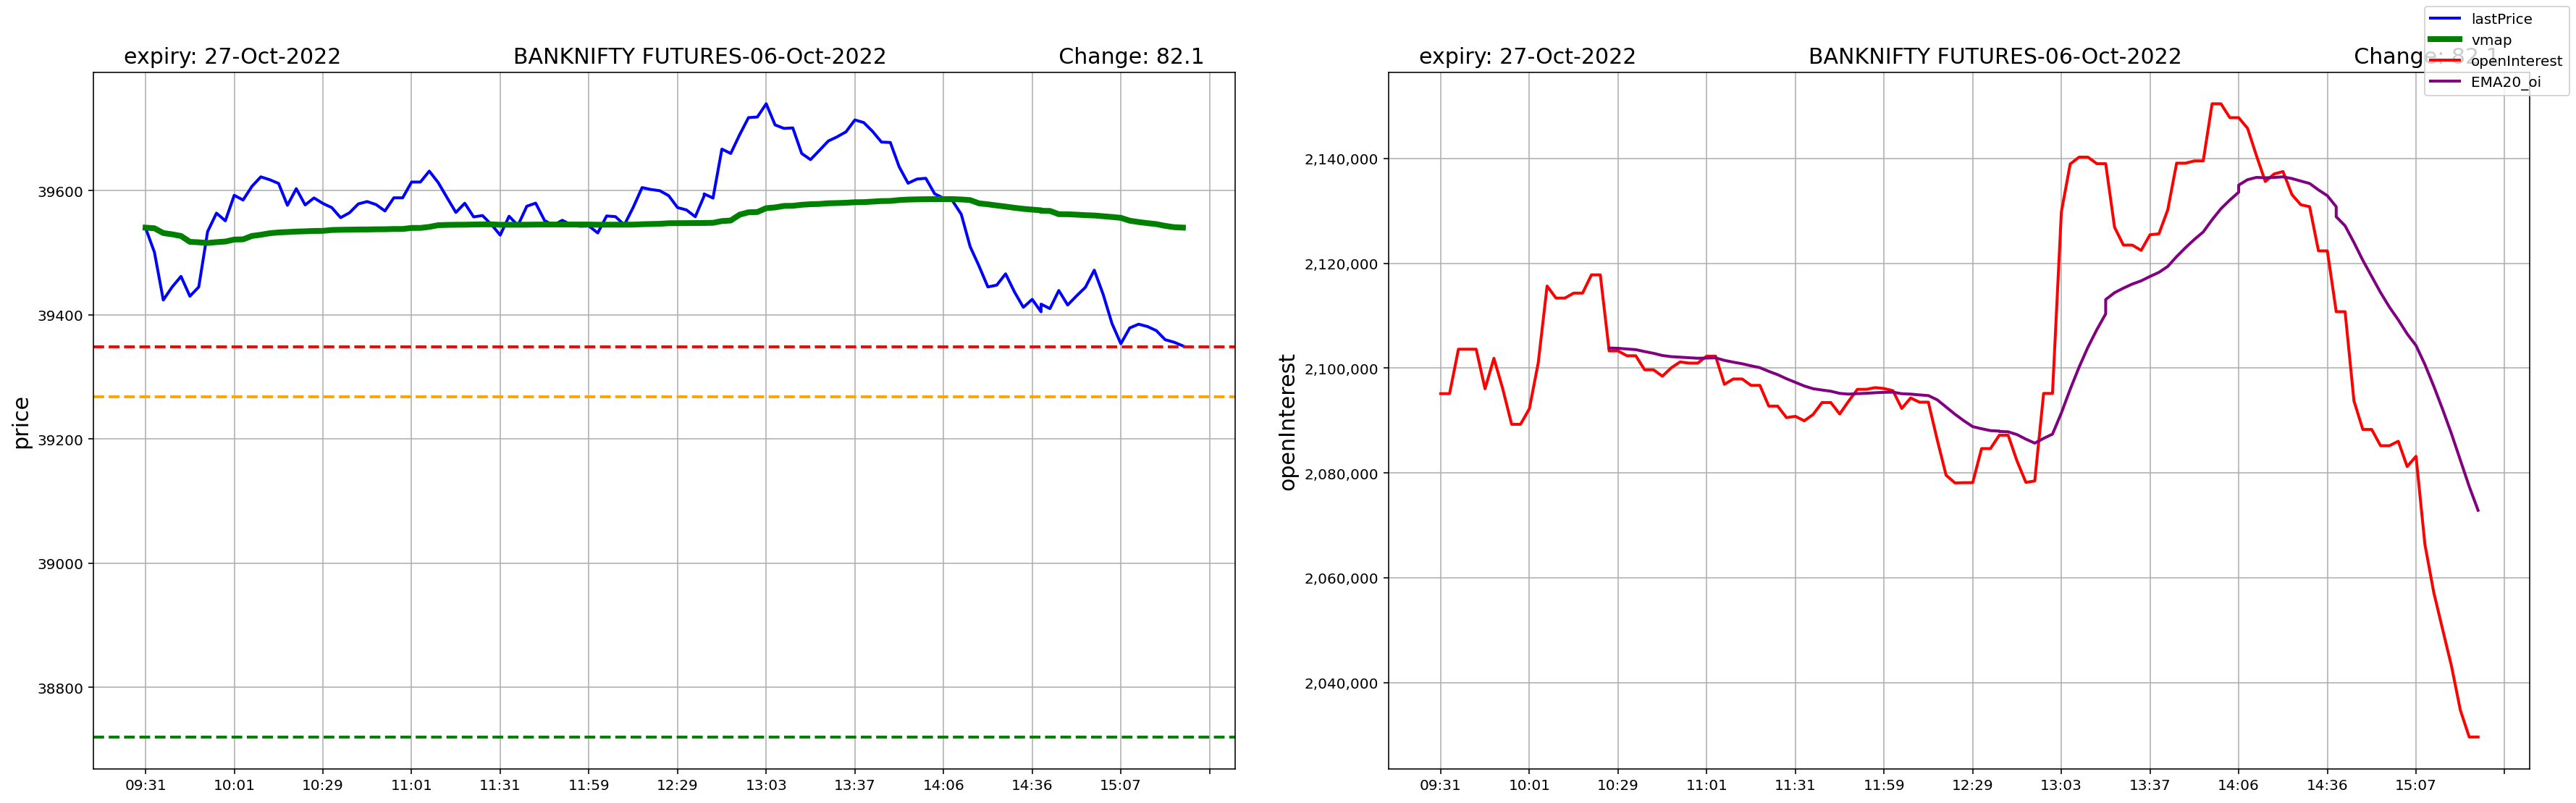

In [47]:
from datetime import timedelta,datetime,date
from nsepy import get_history
import talib as ta

# from datetime import date

def get_today_date_nsepy():
    from datetime import datetime
    date_str = str(datetime.now())
    today=datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S.%f')
    return today.strftime('%Y-%b-%d')

# today_ex=get_today_date_nsepy()

# expiry='2022-Sep-29'
e=datetime.strptime(expiry, '%Y-%b-%d')

t=datetime.strptime(today_ex, '%Y-%b-%d')
d=timedelta(days=1)

# taking care of sunday and saturday
if t.strftime('%A')=='Monday':
    start =t-3*d
    end = t-3*d
else:
    start =t-d
    end = t-d
    

banknifty_fut = get_history(symbol=symbol,
                        start=start,
                        end=end,
                        index=True,
                        futures=True,
                        expiry_date=e)
                            
# if len(banknifty_fut)==0:                # checking if current date is not holiday,like dusshera holiday,then go for a day back
#     start =t-2*d
#     end = t-2*d
#     banknifty_fut = get_history(symbol=symbol,
#                         start=start,
#                         end=end,
#                         index=True,
#                         futures=True,
#                         expiry_date=e)
    
n=2    
while len(banknifty_fut)==0:
    start =t-2*d
    end = t-2*d
    banknifty_fut = get_history(symbol=symbol,
                        start=start,
                        end=end,
                        index=True,
                        futures=True,
                        expiry_date=e)
    n+=1

    
pdc=banknifty_fut["Close"][0]
pdh=banknifty_fut["High"][0]
pdl=banknifty_fut["Low"][0]

df_fut_current_reorder['EMA20_oi'] = ta.EMA(df_fut_current_reorder['openInterest'],20)
df_fut_current_reorder['EMA20_ltp'] = ta.EMA(df_fut_current_reorder['lastPrice'],20)

def get_fut_plot(df,fut,ax,col,clr,ylabel,lw):
    
    chng=round(df["change"].iloc[-1],2)
    ax.plot(df["timestamp"],df[col],label=col,color=clr,linewidth=lw)
    ax.set_xticks(np.arange(0, len(df)+1, 10))# tick labels every (10*3=30)30 min
    for tick in ax.get_xticklabels():  # rotating labels using ax parameter
        tick.set_rotation(0)

    ax.set_title(f"expiry: {expiry_group}"+" "*25+f"{symbol} {fut}-{today}"+" "*25+f"Change: {chng}",size=15)
    ax.set_ylabel(ylabel,size ='15')
    
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values]) 

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,8))#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
get_fut_plot(df_fut_current_reorder,'FUTURES',ax1,"lastPrice",'blue','price',2)
get_fut_plot(df_fut_current_reorder,'FUTURES',ax1,"vmap",'green','price',4)
# get_fut_plot(df_fut_current_reorder,'FUTURES',ax1,"EMA20_ltp",'red','price',2)

ax1.axhline(pdc, color='orange', linestyle='--',linewidth='2')
ax1.axhline(pdh, color='red', linestyle='--',linewidth='2')
ax1.axhline(pdl, color='green', linestyle='--',linewidth='2')

ax1.grid()

get_fut_plot(df_fut_current_reorder,'FUTURES',ax2,"openInterest",'red','openInterest',2)
get_fut_plot(df_fut_current_reorder,'FUTURES',ax2,"EMA20_oi",'purple','openInterest',2)
ax2.grid()

fig.legend()
fig.tight_layout(pad=3)
fig.show()


In [48]:
# len(banknifty_fut)

## Futures details

In [49]:
df_fut_current_reorder_display=df_fut_current_reorder[['timestamp', 'openInterest', 'changeinOpenInterest', 'highPrice',
       'lowPrice', 'tradedVolume', 'lastPrice', 'change', 'vmap',
       'pchangeinOpenInterest', 'prevClose', 'changeLastprice', 'buildup']].dropna() ## dropping EMA_oi and EMA20 from dispaly
# df_fut_current_reorder.style.apply(colour_numbers, axis=0, subset=['buildup']).format(precision=2)
df_fut_current_reorder_display.sort_values(by='timestamp',ascending=False).style.apply(colour_numbers, axis=0, subset=['buildup']).format(precision=2)

,timestamp,openInterest,changeinOpenInterest,highPrice,lowPrice,tradedVolume,lastPrice,change,vmap,pchangeinOpenInterest,prevClose,changeLastprice,buildup
121,15:29,2029650,-20150,39750.00,39350.00,149046,39350.05,82.10,39540.57,-0.98,39267.95,-5.95,SC
120,15:28,2029650,-20150,39750.00,39351.30,148494,39356.00,88.05,39541.27,-0.98,39267.95,-4.00,SC
119,15:25,2034775,-15025,39750.00,39351.30,146813,39360.00,92.05,39543.35,-0.73,39267.95,-14.65,SC
118,15:21,2043175,-6625,39750.00,39351.30,144474,39374.65,106.70,39546.20,-0.32,39267.95,-6.60,SC
117,15:19,2050175,375,39750.00,39351.30,143150,39381.25,113.30,39547.75,0.02,39267.95,-3.75,LB
116,15:16,2057225,7425,39750.00,39351.30,141674,39385.00,117.05,39549.53,0.36,39267.95,6.00,LB
115,15:13,2066400,16600,39750.00,39351.30,139827,39379.00,111.05,39551.68,0.81,39267.95,25.45,LB
114,15:07,2083175,33375,39750.00,39351.65,136229,39353.55,85.60,39556.28,1.63,39267.95,-32.45,LB
113,15:06,2081225,31425,39750.00,39366.15,135225,39386.00,118.05,39557.70,1.53,39267.95,-47.15,LB
112,15:04,2086050,36250,39750.00,39366.15,134207,39433.15,165.20,39558.87,1.77,39267.95,-38.85,LB
